# Libararies intallation

In [9]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Data Preprocessing: Detect face and eyes

In [2]:
img = cv2.imread('./test_images/jade.png')
img.shape

(200, 200, 3)

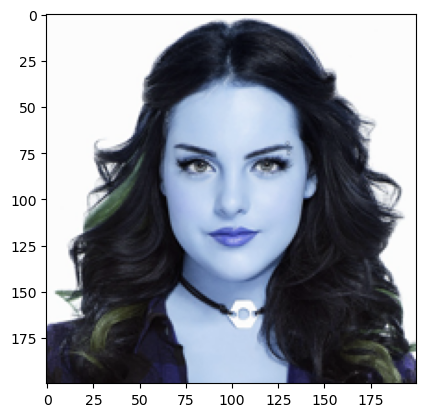

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(200, 200)

In [5]:
gray

array([[252, 252, 252, ..., 252, 252, 252],
       [252, 252, 252, ..., 252, 252, 252],
       [252, 252, 252, ..., 252, 252, 252],
       ...,
       [ 27,  23,  23, ...,  64,  70,  64],
       [ 29,  29,  25, ...,  49,  62,  55],
       [ 30,  29,  26, ...,  51,  52,  39]], dtype=uint8)

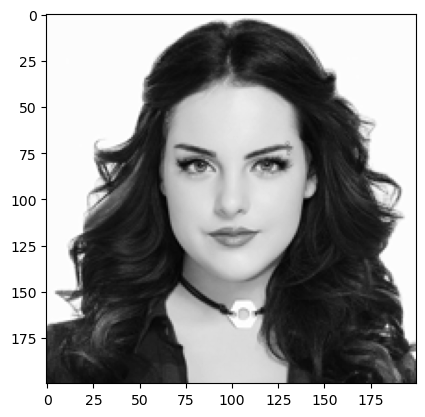

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 50,  42, 101, 101]])

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(50, 42, 101, 101)

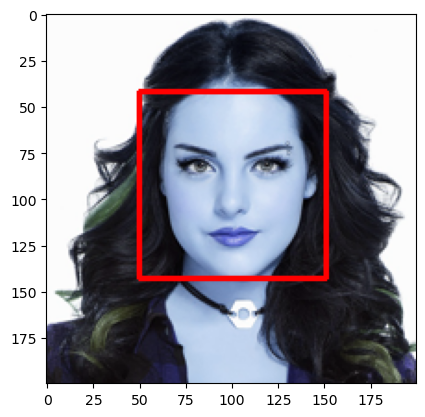

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

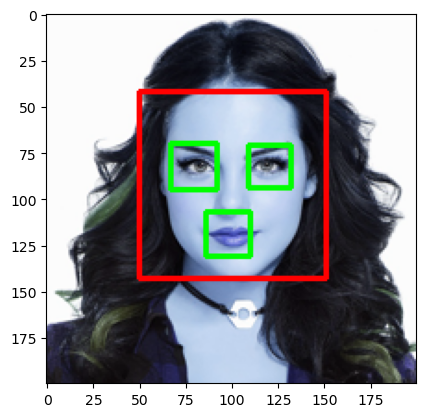

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

# Data Preprocessing: Crop the facial region of the image

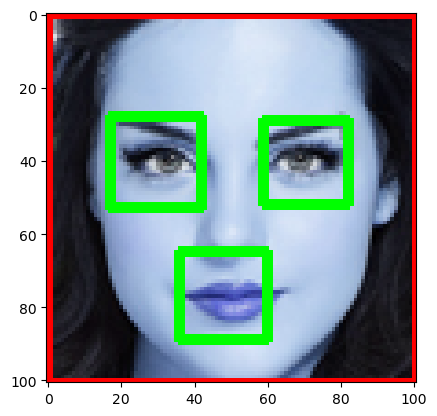

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

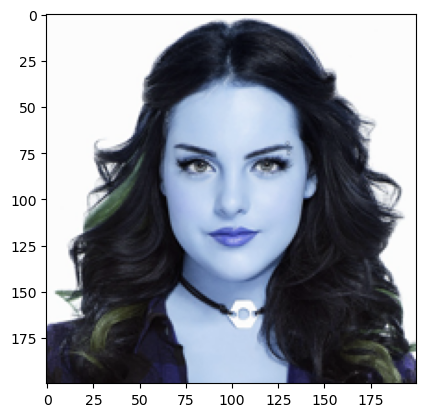

In [13]:
original_image = cv2.imread('./test_images/jade.png')
plt.imshow(original_image)

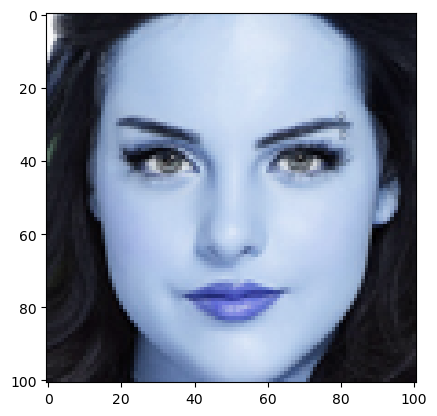

In [14]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/jade.png')
plt.imshow(cropped_image)

In [15]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [16]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [17]:
img_dirs

['./dataset/Beck', './dataset/Cat', './dataset/Jade', './dataset/Tori']

In [18]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [19]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1  

Beck
Generating cropped images in folder:  ./dataset/cropped/Beck
Cat
Generating cropped images in folder:  ./dataset/cropped/Cat
Jade
Generating cropped images in folder:  ./dataset/cropped/Jade
Tori
Generating cropped images in folder:  ./dataset/cropped/Tori


# Data Preprocessing: Use wavelet transform as a feature for traning our model

In [20]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [33]:
cropped_img = cv2.imread('./cropped_img/Cat1.png')
cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

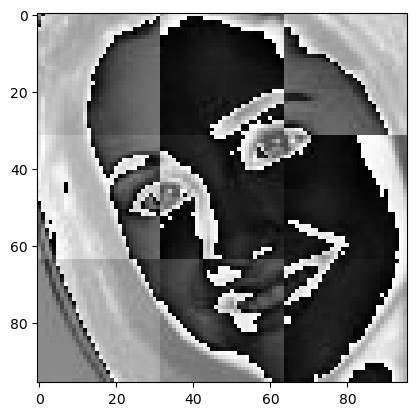

In [35]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

# Preparing X and Y

In [36]:
celebrity_file_names_dict

{'Beck': ['./dataset/cropped/Beck/Beck1.png',
  './dataset/cropped/Beck/Beck2.png',
  './dataset/cropped/Beck/Beck3.png',
  './dataset/cropped/Beck/Beck4.png',
  './dataset/cropped/Beck/Beck5.png',
  './dataset/cropped/Beck/Beck6.png',
  './dataset/cropped/Beck/Beck7.png',
  './dataset/cropped/Beck/Beck8.png',
  './dataset/cropped/Beck/Beck9.png',
  './dataset/cropped/Beck/Beck10.png',
  './dataset/cropped/Beck/Beck11.png',
  './dataset/cropped/Beck/Beck12.png',
  './dataset/cropped/Beck/Beck13.png',
  './dataset/cropped/Beck/Beck14.png',
  './dataset/cropped/Beck/Beck15.png',
  './dataset/cropped/Beck/Beck16.png',
  './dataset/cropped/Beck/Beck17.png',
  './dataset/cropped/Beck/Beck18.png',
  './dataset/cropped/Beck/Beck19.png',
  './dataset/cropped/Beck/Beck20.png',
  './dataset/cropped/Beck/Beck21.png',
  './dataset/cropped/Beck/Beck22.png',
  './dataset/cropped/Beck/Beck23.png',
  './dataset/cropped/Beck/Beck24.png',
  './dataset/cropped/Beck/Beck25.png',
  './dataset/cropped/Beck/

In [37]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Beck': 0, 'Cat': 1, 'Jade': 2, 'Tori': 3}

In [39]:
X, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)

        # Error handling for image loading
        if img is None:
            print(f"Error: Image {training_image} could not be loaded.")
            continue  # Skip this iteration if image can't be loaded

        try:
            # Resize the raw image
            scalled_raw_img = cv2.resize(img, (32, 32))
            
            # Apply wavelet transformation
            img_har = w2d(img, 'db1', 5)
            
            # Resize the wavelet-transformed image
            scalled_img_har = cv2.resize(img_har, (32, 32))
            
            # Reshape both raw and wavelet images
            reshaped_raw_img = scalled_raw_img.reshape(32 * 32 * 3, 1)  # Raw image in 1D (3 channels)
            reshaped_img_har = scalled_img_har.reshape(32 * 32, 1)      # Wavelet image in 1D (grayscale)
            
            # Combine the raw image and wavelet-transformed image
            combined_img = np.vstack((reshaped_raw_img, reshaped_img_har))
            
            # Add the combined image and corresponding label to X and y
            X.append(combined_img)
            y.append(class_dict[celebrity_name])
        
        except Exception as e:
            print(f"Error processing image {training_image}: {e}")
            continue  # Skip this iteration if there's an error during processing


Error: Image ./dataset/cropped/Beck/Beck2.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade25.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade42.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade45.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade46.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade47.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade49.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade51.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade64.png could not be loaded.
Error: Image ./dataset/cropped/Jade/Jade65.png could not be loaded.


In [40]:
len(X[0])

4096

In [41]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(135, 4096)

# Model Building

In [43]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7647058823529411

In [45]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.00      0.00      0.00         3
           2       0.80      0.94      0.86        17
           3       0.83      0.83      0.83         6

    accuracy                           0.76        34
   macro avg       0.62      0.60      0.60        34
weighted avg       0.74      0.76      0.75        34



# Trying different models using gridsearch

In [46]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [47]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [48]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.831905,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.652857,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.831905,{'logisticregression__C': 1}


In [49]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [50]:
best_estimators['svm'].score(X_test,y_test)

0.8235294117647058

In [52]:
best_estimators['random_forest'].score(X_test,y_test)

0.5

In [53]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8529411764705882

In [58]:
best_clf = best_estimators['svm']

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 6,  1,  1,  0],
       [ 1,  1,  0,  1],
       [ 1,  1, 15,  0],
       [ 0,  0,  0,  6]], dtype=int64)

In [62]:
pip install --upgrade seaborn numpy


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ------ --------------------------------- 10.2/59.7 kB ? eta -:--:--
     ------------------- ------------------ 30.7/59.7 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 59.7/59.7 kB 396.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   -------- ------------------------------- 61.4/294.9 kB 1.1 MB/s eta 0:00:01
   ---------- ---------------------------- 81.9/294.9 kB 770.8 kB/s eta 0:00:01
   ----------------------- ---------------- 174.1/294.9 kB 1.2 MB/s eta 0:00:01
   --------------------------------- ------ 245.8/294.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.

In [61]:
class_dict

{'Beck': 0, 'Cat': 1, 'Jade': 2, 'Tori': 3}

# Save the model

In [64]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

Defaulting to user installation because normal site-packages is not writeable


['saved_model.pkl']

# Save class dictionary

In [65]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))